In [211]:
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib
import re
import nltk
import numpy
import pickle
import warnings
import numpy as np
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.corpus import swadesh
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.naive_bayes import MultinomialNB
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('words')
nltk.download('swadesh')
warnings.filterwarnings('ignore')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/giorgiomondauto/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/giorgiomondauto/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     /Users/giorgiomondauto/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package swadesh to
[nltk_data]     /Users/giorgiomondauto/nltk_data...
[nltk_data]   Package swadesh is already up-to-date!


In [212]:
professioni = pd.read_csv('data/professioni.csv')
dati_aprile = pd.read_csv('Job_vacancies_aprile_completo.csv', skiprows=1, usecols = [1,2,3],\
                          names = ['Target','Sub_Role','Job_Description'])
dati_aprile = dati_aprile.reindex(np.random.permutation(dati_aprile.index))
print('dati_aprile shape {}'.format(dati_aprile.shape))
dati_aprile.head()

dati_aprile shape (650, 3)


,Target,Sub_Role,Job_Description
216,Statistici,BIG DATA ANALYST - DATA SCIENTIST,Estrazione di nuovi dati dai Sistemi Operazion...
236,Statistici,Junior Data Scientist,Le risorse saranno inserite in un contesto Ana...
155,Cuochi in alberghi e ristoranti,Cuoco,Cuoco e Aiuto Cuoco per Castellammare Del Golf...
568,Commessi delle vendite al minuto,Addetto al rifornimento degli scaffali negli e...,Addetto rifornimento scaffali. Le risorse ins...
249,Statistici,Market Research Analyst,La risorsa sarà inserita in supporto alla Busi...


In [213]:
print(dati_aprile.Target.value_counts())

Commessi delle vendite al minuto    149
Statistici                          104
Camerieri di ristorante             100
Cuochi in alberghi e ristoranti     100
Elettromeccanici                     99
Tecnici web                          98
Name: Target, dtype: int64


In [214]:
professioni.head()

,Group,Subgroup,Descrizione_professione,Descrizione_professione2,subgroup1,subgroup2,Esco_Abilit_compet_essenz,Esco_conoscenze_essenz,Esco_Abilit_compet_opz,Conoscenze
0,Statistici,Attuario\nData scientist\nEsperto in ricerca o...,Accertamenti tecnici per la valutazione delle ...,Elaborare piani tecnici per la trasformazione ...,consulente attuariale\ndemografo demografa\nsp...,consulente attuariale\ndemografo demografa\nsp...,correggere i dati\ncostruire sistemi di raccom...,classificazione delle informazioni\nelaborazio...,creare modelli di dati\ndefinire criteri di qu...,LDAP\nLINQ\nMDX\nN1QL\nSPARQL\nXQuery\nbusines...
1,Cuochi in alberghi e ristoranti,Aiuto cuoco\nAiuto cuoco di ristorante\nAntipa...,Allestimento dei piatti\nApplicazione delle pr...,Effettuare la preparazione dell'impasto da piz...,capo chef pasticcere capo chef pasticcera\nche...,addetta alla preparazione degli alimenti\ncuoc...,consegnare la zona di preparazione di alimenti...,"legislazione in materia di salute, sicurezza e...",NaN,NaN
2,Commessi alle vendite al minuto,Addetto al banco vendita di macelleria\nAddett...,Allestimento degli scaffali e delle isole prom...,Allestire e rifornire gli scaffali e le isole ...,commesso di negozio di abbigliamento commessa ...,commessa di negozio di abbigliamento uomo donn...,applicare le competenze matematiche\nconsiglia...,argomentazione di vendita\ncaratteristiche dei...,eseguire piccoli interventi di sartoria,industria dell'abbigliamento
3,Elettromeccanici,Aggiustatore elettromeccanico\nAvvolgitore di ...,Cablatura dell'impianto elettrico\nCollaudo de...,Effettuare la diagnosi tecnica (strumentale e ...,manutentore elettromeccanico manutentrice elet...,elettricista a bordo macchina\nelettricista-me...,adattare le attrezzature meccanizzate\napplica...,elettricità\nelettromeccanica\nelettronica\nme...,applicare un rivestimento alle apparecchiature...,accessori per cavi elettrici\ncomponenti di ba...


#### Text Processing on Professioni

In [215]:
def readable_format(dataset):
    ''' convert data into a readable format '''
    dataset.Subgroup = dataset.Subgroup.apply(lambda x: x.lower().split('\n'))
    dataset.Subgroup = dataset.Subgroup.apply(lambda x: [i.split("'") for i in x])

    dataset.subgroup1 = dataset.subgroup1.apply(lambda x: x.lower().split('\n'))
    dataset.subgroup1 = dataset.subgroup1.apply(lambda x: [i.split("'") for i in x])

    dataset.subgroup2 = dataset.subgroup2.apply(lambda x: x.lower().split('\n'))
    dataset.subgroup2 = dataset.subgroup2.apply(lambda x: [i.split("'") for i in x])

    dataset.Subgroup = dataset.Subgroup + professioni.subgroup1 + professioni.subgroup2
    dataset.Subgroup  = dataset.Subgroup.apply(lambda x: [ i for t in x for i in t])
    dataset.Subgroup = dataset.Subgroup.apply(lambda x: list(set(x)))
    
    # the following removes empty space from the subgroup list of values
    for i in range(0,dataset.Subgroup.shape[0]):
        while("" in dataset.Subgroup.iloc[i]) : 
            dataset.Subgroup.iloc[i].remove("") 
    
    return dataset

def list_of_skills(dataset):
    ''' to get list of skills from professioni dataset'''
    dataset1 = dataset.copy()
    dataset1.Conoscenze = dataset1.Conoscenze.apply(lambda x: str(x).lower().split('\n'))
    dataset1.Conoscenze = dataset1.Conoscenze.apply(lambda x: [i.split("'") for i in x])
    dataset1.Conoscenze = dataset1.Conoscenze.apply(lambda x: [i for t in x for i in t])
    Conoscenze_lista = []
    for i in dataset1.Conoscenze:
        for item in i:
            Conoscenze_lista.append(item)
    return Conoscenze_lista


def get_role_info(dataset, Conoscenze_lista):
    ''' create a column which capture role description '''
    dataset.Descrizione_professione = dataset.Descrizione_professione.apply(lambda x: x.lower().split('\n'))
    dataset.Descrizione_professione = dataset.Descrizione_professione.apply(lambda x: [i.split("'") for i in x])

    dataset.Descrizione_professione2 = dataset.Descrizione_professione2.apply(lambda x: x.lower().split('\n'))
    dataset.Descrizione_professione2 = dataset.Descrizione_professione2.apply(lambda x: [i.split("'") for i in x])

    dataset.Conoscenze = dataset.Conoscenze.apply(lambda x: str(x).lower().split('\n'))
    dataset.Conoscenze = dataset.Conoscenze.apply(lambda x: [i.split("'") for i in x])
    dataset['Descrizione_all'] = dataset.Descrizione_professione + professioni.Descrizione_professione2 + professioni.Conoscenze
    dataset['Descrizione_all'] = dataset.Descrizione_all .apply(lambda x: [ i for t in x for i in t])
    dataset['Descrizione_all']= dataset.Descrizione_all.apply(lambda x: [i.split("/") for i in x])
    dataset['Descrizione_all'] = dataset.Descrizione_all .apply(lambda x: [ i for t in x for i in t])
    
    dataset['Descrizione_all'] = dataset.Descrizione_all .apply(lambda x: list(set(x)))
    
    # to remove empty space
    for i in range(0,dataset.Descrizione_all.shape[0]):
        while("" in dataset.Descrizione_all.iloc[i]) : 
            dataset.Descrizione_all.iloc[i].remove("") 
    # remove punctuation and tokeniz
    dataset.Descrizione_all = dataset.Descrizione_all.apply(lambda x: list(set([t for i in x for t in \
                                                                                word_tokenize(i)])))
    
    dataset.Descrizione_all = dataset.Descrizione_all.apply(lambda x: [i for i in x if (len(i) > 3 or \
                                                                                    i in Conoscenze_lista)])
    
    dataset.Descrizione_all = dataset.Descrizione_all.apply(lambda x: [i for i in x if not (i.startswith('nan') or\
                                                                    i.startswith('dell') \
                                                                    or i.startswith('sull')\
                                                                     or i.startswith('degl')
                                                                     or i.startswith('dall')
                                                                     or i.startswith('all'))])
    return dataset


def get_info_to_use(dataset, column):
    ''' to export info into a csv file'''
    info_data = dataset[column]
    info_data.Conoscenze = info_data.Conoscenze.apply(lambda x: [i for t in x for i in t])
    info_data.Conoscenze = info_data.Conoscenze.apply(lambda x: ' '.join(x))
    info_data.Descrizione_all = info_data.Descrizione_all.apply(lambda x: ' '.join(x))
    info_data['info'] = info_data['Descrizione_all'] + ' ' + info_data['Conoscenze']
    info_data['info'] = info_data['info'].apply(lambda x: [i for i in word_tokenize(x)])
    info_data.drop(['Conoscenze','Descrizione_all'], axis = 1, inplace = True)
    info_data['info'] = info_data['info'].apply(lambda x: [i for i in x if (len(i) > 3 or i in Conoscenze_lista)])

    info_data['info']= info_data['info'].apply(lambda x: [i for i in x if not (i.startswith('loro') or\
                                                                           i.startswith('nan') or\
                                                                    i.startswith('dell') \
                                                                    or i.startswith('sull')\
                                                                     or i.startswith('degl')
                                                                     or i.startswith('dall')
                                                                     or i.startswith('all')
                                                                          )])
    info_data.Group = info_data.Group.replace('Commessi alle vendite al minuto','Commessi delle vendite al minuto')
    info_data.to_csv('info_data.csv')
    return info_data

def remove_uncommon_it_words(dataset):
    ''' to get rid of uncommon words '''
    uncommon_it_words = swadesh.words('it')
    dataset['Descrizione_all'] = dataset['Descrizione_all'].apply(lambda x: [i for i in x if i not in uncommon_it_words])
    return dataset

In [216]:
Conoscenze_lista = list_of_skills(professioni)
print('Lista delle Skills \n', Conoscenze_lista)
print(20 * '%')
professioni = readable_format(professioni)
professioni = get_role_info(professioni, Conoscenze_lista)
# professioni['Descrizione_all'] = remove_uncommon_it_words(professioni)
column = ['Conoscenze','Descrizione_all','Group']
info_data = get_info_to_use(professioni, column)
professioni = remove_uncommon_it_words(professioni)
professioni[['Group','Subgroup','Descrizione_all']].head()

Lista delle Skills 
 ['ldap', 'linq', 'mdx', 'n1ql', 'sparql', 'xquery', 'business intelligence', 'dati non strutturati', 'valutazione della qualità dei dati', 'nan', 'industria dell', 'abbigliamento', 'accessori per cavi elettrici', 'componenti di batterie', 'generatori elettrici', 'metodi di collaudo elettrico', 'piani di cablaggio elettrico', 'tecniche di brasatura', 'tecnologia per l', 'automazione']
%%%%%%%%%%%%%%%%%%%%


,Group,Subgroup,Descrizione_all
0,Statistici,"[statistico metodologico, statistico economico...","[acquisiti, economiche, gestione, determinando..."
1,Cuochi in alberghi e ristoranti,"[aiuto cuoco, cuoca privata, cuoco di albergo,...","[applicando, gestione, elettrico, stato, idone..."
2,Commessi alle vendite al minuto,"[addetto vendita di prodotti caseari, commesso...","[suggerimenti, inventario, stoccaggio, aliment..."
3,Elettromeccanici,"[elettromeccanico, elettricista-meccanico, ria...","[interpretazione, cicli, elettrico, stato, dan..."


##### Create a dictionary for professioni. e.g.
{Statistici : ['attuario', 'data scientist', 'esperto in ricerca operativa',..... ]}

In [217]:
def dict_professioni(dataset):
    ''' to create a dictionary for professioni '''
    professioni_dictionary = pd.Series(dataset.Subgroup.values,index=dataset.Group).to_dict()
    # I need this step to convert back
    subgroup_dict = {}
    for group, subgroups in professioni_dictionary.items():
        for subgroup in subgroups:
            subgroup_dict[subgroup] = group
    
    return professioni_dictionary, subgroup_dict

#### Text Preprocessing on vacancies


In [218]:
def text_preprocessing(dataset, Conoscenze_lista):
    ''' remove punctuation,noise and tokenize '''
    dataset.Job_Description = dataset.Job_Description.apply(lambda x: re.sub('[^a-zA-Z]',' ',x))
    dataset.Job_Description = dataset['Job_Description'].apply(lambda x: word_tokenize(x.lower())) # lowercase each word
    
    # to get rid of short words (len < 3) which are not skills
    dataset.Job_Description= dataset.Job_Description.apply(lambda x: [i for i in x if (len(i) > 3 \
                                                                                       or i in Conoscenze_lista)])
    
    # remove in 'job_description' words from 'fonte'
    Fonti = ['randstad', 'monster', 'infojob', 'technical', 'kelly', 'services', 'italia', 'lavoropi',\
             'quanta','vimercate','temporary','openjobmetis','agenzia']
    dataset.Job_Description = dataset.Job_Description.apply(lambda x: [i for i in x if i not in Fonti])
    # to remove italian stop words
    list_stopwords = list(set(stopwords.words('italian')))
    dataset.Job_Description = dataset.Job_Description.apply(lambda x: [i for i in x if i not in list_stopwords])    

    ## remove words like dell, della, dello, sull, degl. etc.
    dataset.Job_Description = dataset.Job_Description.apply(lambda x: [i for i in x if not (i.startswith('dell') \
                                                                        or i.startswith('sull')\
                                                                         or i.startswith('degl')
                                                                         or i.startswith('dall')
                                                                         or i.startswith('all')
                                                                       or i.strip().startswith('kell'))])
    dataset.drop('Sub_Role',axis = 1, inplace = True)
    return dataset

def remove_comuni(dataset, column, geo_dataset):
    ''' function to remove geographic noise '''
    
    geo_data = pd.read_fwf(geo_dataset)
    geo_data.to_csv('listacomuni.csv')
    geo_data = pd.read_csv('listacomuni.csv', sep=';')
    comune = [i.lower() for i in geo_data.Comune]
    geo_data.Provincia = geo_data.Provincia.apply(lambda x: str(x))
    provincia = [i.lower() for i in geo_data.Provincia]
    regione = [i.lower() for i in geo_data.Regione]
    
    dataset[column] = dataset[column].apply(lambda x: [i for i in x if i not in comune])
    dataset[column] = dataset[column].apply(lambda x: [i for i in x if i not in provincia])
    dataset[column] = dataset[column].apply(lambda x: [i for i in x if i not in regione])
    
    return dataset

In [219]:
dati_aprile = text_preprocessing(dati_aprile, Conoscenze_lista)
dati_aprile.head()

,Target,Job_Description
216,Statistici,"[estrazione, nuovi, dati, sistemi, operazional..."
236,Statistici,"[risorse, inserite, contesto, analytics, forte..."
155,Cuochi in alberghi e ristoranti,"[cuoco, aiuto, cuoco, castellammare, golfo, ri..."
568,Commessi delle vendite al minuto,"[addetto, rifornimento, scaffali, risorse, ins..."
249,Statistici,"[risorsa, inserita, supporto, business, unit, ..."


In [220]:
dati_aprile = remove_comuni(dati_aprile, 'Job_Description', geo_dataset = 'data/listacomuni.txt')
dati_aprile.head() # note row 1: before there was verona, now it was cut out

,Target,Job_Description
216,Statistici,"[estrazione, nuovi, dati, sistemi, operazional..."
236,Statistici,"[risorse, inserite, contesto, analytics, forte..."
155,Cuochi in alberghi e ristoranti,"[cuoco, aiuto, cuoco, castellammare, golfo, ri..."
568,Commessi delle vendite al minuto,"[addetto, rifornimento, scaffali, risorse, ins..."
249,Statistici,"[risorsa, inserita, supporto, business, unit, ..."


In [221]:
def role_dictionary(dataset):
    ''' encode the role column '''
    Role_dictionary = pd.Series(dataset['Target'].unique()).to_dict()
    Role_dictionary = dict([(value, key) for key, value in Role_dictionary.items()])

    # save role dictionary as picke file
    with open('Role_dictionary.pickle', 'wb') as handle:
        pickle.dump(Role_dictionary, handle, protocol=pickle.HIGHEST_PROTOCOL)

    with open('Role_dictionary.pickle', 'rb') as handle:
        b = pickle.load(handle)

    role_encoded = []
    for i in dataset.Target:
        role_encoded.append(Role_dictionary.get(i, None))
    
    dataset['Role'] = role_encoded
    
    return dataset, Role_dictionary

In [222]:
dati_aprile,Role_dictionary = role_dictionary(dati_aprile)

In [223]:
Role_dictionary

{'Statistici': 0,
 'Cuochi in alberghi e ristoranti': 1,
 'Commessi delle vendite al minuto': 2,
 'Tecnici web': 3,
 'Camerieri di ristorante': 4,
 'Elettromeccanici': 5}

#### Stemming / Lemmatization
Stemming: Stemming algorithms work by cutting off the end of the word, and in some cases also the beginning while looking for the root. This indiscriminate cutting can be successful in some occasions, but not always, that is why we affirm that this an approach that offers some limitations. ex) studying -> study, studied -> studi

Lemmatization: Lemmatization is the process of converting the words of a sentence to its dictionary form. For example, given the words amusement, amusing, and amused, the lemma for each and all would be amuse. ex) studying -> study, studied -> study. Lemmatization also discerns the meaning of the word by understanding the context of a passage. For example, if a "meet" is used as a noun then it will print out a "meeting"; however, if it is used as a verb then it will print out "meet".

We go for stemming

In [224]:
def stemming(dataset, info_data):
    ''' stemming a text '''
    stemmer = nltk.stem.snowball.ItalianStemmer(ignore_stopwords=False)
    dataset['Job_Description'] = dataset['Job_Description'].apply(lambda x: [stemmer.stem(i) \
                                                                        for i in x])
    info_data['info'] = info_data['info'].apply(lambda x: [stemmer.stem(i) for i in x])
    return dataset, info_data

In [225]:
dati_aprile, info_data = stemming(dati_aprile,info_data)
dati_aprile.head()

,Target,Job_Description,Role
216,Statistici,"[estrazion, nuov, dat, sistem, operazional, al...",0
236,Statistici,"[risors, inser, contest, analytics, fortement,...",0
155,Cuochi in alberghi e ristoranti,"[cuoc, aiut, cuoc, castellamm, golf, richied, ...",1
568,Commessi delle vendite al minuto,"[addett, riforn, scaffal, risors, inser, occup...",2
249,Statistici,"[risors, inser, support, business, unit, indag...",0


In [226]:
info_data.head()

,Group,info
0,Statistici,"[acquis, econom, gestion, determin, interpret,..."
1,Cuochi in alberghi e ristoranti,"[applic, gestion, elettr, stat, idone, artist,..."
2,Commessi delle vendite al minuto,"[sugger, inventar, stoccagg, alimentar, smist,..."
3,Elettromeccanici,"[interpret, cicl, elettr, stat, dannegg, indic..."


In [227]:
dati_aprile.Target.unique()

array(['Statistici', 'Cuochi in alberghi e ristoranti',
       'Commessi delle vendite al minuto', 'Tecnici web',
       'Camerieri di ristorante', 'Elettromeccanici'], dtype=object)

#### Prepare data for training

In [228]:
#### Create one hot encoded columns for each word in info_data.Info
all_words = []
for i in info_data['info']:
    all_words.append(i)
lista_info_words = list(set([i for x in all_words for i in x]))

for i in lista_info_words:
    dati_aprile[i] = dati_aprile['Job_Description'].apply(lambda x:  1 if i in x else 0)

dati_aprile['Job_Description'] = dati_aprile.Job_Description.apply(lambda x: ' '.join(x))
print(dati_aprile.shape)
dati_aprile.head()

(650, 434)


,Target,Job_Description,Role,megl,puliz,ten,element,specific,infin,carn,...,accopp,imbarc,misur,assegn,attrezzatur,vend,disposizion,assicur,artist,dinam
216,Statistici,estrazion nuov dat sistem operazional altre fo...,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
236,Statistici,risors inser contest analytics fortement dinam...,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
155,Cuochi in alberghi e ristoranti,cuoc aiut cuoc castellamm golf richied esperit...,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
568,Commessi delle vendite al minuto,addett riforn scaffal risors inser occup segue...,2,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
249,Statistici,risors inser support business unit indagin sta...,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [229]:
X = dati_aprile.copy()
X.drop(['Role','Target'], axis = 1, inplace = True)
y = dati_aprile['Role']
X.head()
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.20,
                                                    random_state=42)
print('Number of rows in the total set: {}'.format(dati_aprile.shape))
print('Number of rows in the training set: {}'.format(X_train.shape))
print('Number of rows in the test set: {}'.format(X_test.shape))

Number of rows in the total set: (650, 434)
Number of rows in the training set: (520, 432)
Number of rows in the test set: (130, 432)


#### Bag of Words processing to our dataset
cv = CountVectorizer(max_df=0.8,stop_words=stop_words, max_features=10000, ngram_range=(1,3))

#### max_df:
When building the vocabulary ignore terms that have a document frequency strictly higher than the given threshold (corpus-specific stop words). This is to ensure that we only have words relevant to the context and not commonly used words.

#### max_features:
determines the number of columns in the matrix.

#### n-gram
range: we would want to look at a list of single words, two words (bi-grams) and three words (tri-gram) combinations.

count_vector = CountVectorizer(max_df = 0.8, ngram_range=(1,3))

In [233]:
# count_vector = CountVectorizer(max_df = 0.8, ngram_range=(1,3))

# # Fit the training data and then return the matrix
# training_data = count_vector.fit_transform(X_train['Job_Description']).toarray()

# # Transform testing data and return the matrix. Note we are not fitting the testing data into the CountVectorizer()
# testing_data = count_vector.transform(X_test['Job_Description']).toarray()

# training_data.shape

(520, 57456)

In [240]:
# training_data = numpy.concatenate((training_data, X_train.iloc[:,1:].to_numpy()), axis = 1)
# testing_data = numpy.concatenate((testing_data, X_test.iloc[:,1:].to_numpy()), axis = 1)
# print('training data',training_data.shape)
# print('testing data',testing_data.shape)

training data (520, 8270)
testing data (130, 2215)


In [248]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(sublinear_tf= True, min_df = 2, norm = 'l2', ngram_range=(1,2))

features = tfidf.fit_transform(dati_aprile['Job_Description']).toarray()
labels = y

In [245]:
print(features.shape)

(650, 9463)


In [249]:
from sklearn.feature_selection import chi2
import numpy as np
category_to_id = dict(dati_aprile.Role)
N = 2
for Product, category_id in sorted(category_to_id.items()):
  features_chi2 = chi2(features, labels == category_id)
  indices = np.argsort(features_chi2[0])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
  print("# '{}':".format(Product))
  print("  . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-N:])))
  print("  . Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-N:])))

# '0':
  . Most correlated unigrams:
. meccan
. elettr
  . Most correlated bigrams:
. manutentor elettromeccan
. schem elettr
# '1':
  . Most correlated unigrams:
. meccan
. elettr
  . Most correlated bigrams:
. manutentor elettromeccan
. schem elettr
# '2':
  . Most correlated unigrams:
. meccan
. elettr
  . Most correlated bigrams:
. manutentor elettromeccan
. schem elettr
# '3':
  . Most correlated unigrams:
. meccan
. elettr
  . Most correlated bigrams:
. manutentor elettromeccan
. schem elettr
# '4':
  . Most correlated unigrams:
. meccan
. elettr
  . Most correlated bigrams:
. manutentor elettromeccan
. schem elettr
# '5':
  . Most correlated unigrams:
. meccan
. elettr
  . Most correlated bigrams:
. manutentor elettromeccan
. schem elettr
# '6':
  . Most correlated unigrams:
. meccan
. elettr
  . Most correlated bigrams:
. manutentor elettromeccan
. schem elettr
# '7':
  . Most correlated unigrams:
. meccan
. elettr
  . Most correlated bigrams:
. manutentor elettromeccan
. schem

# '70':
  . Most correlated unigrams:
. meccan
. elettr
  . Most correlated bigrams:
. manutentor elettromeccan
. schem elettr
# '71':
  . Most correlated unigrams:
. meccan
. elettr
  . Most correlated bigrams:
. manutentor elettromeccan
. schem elettr
# '72':
  . Most correlated unigrams:
. meccan
. elettr
  . Most correlated bigrams:
. manutentor elettromeccan
. schem elettr
# '73':
  . Most correlated unigrams:
. meccan
. elettr
  . Most correlated bigrams:
. manutentor elettromeccan
. schem elettr
# '74':
  . Most correlated unigrams:
. meccan
. elettr
  . Most correlated bigrams:
. manutentor elettromeccan
. schem elettr
# '75':
  . Most correlated unigrams:
. meccan
. elettr
  . Most correlated bigrams:
. manutentor elettromeccan
. schem elettr
# '76':
  . Most correlated unigrams:
. meccan
. elettr
  . Most correlated bigrams:
. manutentor elettromeccan
. schem elettr
# '77':
  . Most correlated unigrams:
. meccan
. elettr
  . Most correlated bigrams:
. manutentor elettromeccan

# '143':
  . Most correlated unigrams:
. cucin
. cuoc
  . Most correlated bigrams:
. prepar piatt
. aiut cuoc
# '144':
  . Most correlated unigrams:
. cucin
. cuoc
  . Most correlated bigrams:
. prepar piatt
. aiut cuoc
# '145':
  . Most correlated unigrams:
. cucin
. cuoc
  . Most correlated bigrams:
. prepar piatt
. aiut cuoc
# '146':
  . Most correlated unigrams:
. cucin
. cuoc
  . Most correlated bigrams:
. prepar piatt
. aiut cuoc
# '147':
  . Most correlated unigrams:
. cucin
. cuoc
  . Most correlated bigrams:
. prepar piatt
. aiut cuoc
# '148':
  . Most correlated unigrams:
. cucin
. cuoc
  . Most correlated bigrams:
. prepar piatt
. aiut cuoc
# '149':
  . Most correlated unigrams:
. cucin
. cuoc
  . Most correlated bigrams:
. prepar piatt
. aiut cuoc
# '150':
  . Most correlated unigrams:
. cucin
. cuoc
  . Most correlated bigrams:
. prepar piatt
. aiut cuoc
# '151':
  . Most correlated unigrams:
. cucin
. cuoc
  . Most correlated bigrams:
. prepar piatt
. aiut cuoc
# '152':
 

# '218':
  . Most correlated unigrams:
. dat
. statist
  . Most correlated bigrams:
. analis dat
. machin learning
# '219':
  . Most correlated unigrams:
. dat
. statist
  . Most correlated bigrams:
. analis dat
. machin learning
# '220':
  . Most correlated unigrams:
. dat
. statist
  . Most correlated bigrams:
. analis dat
. machin learning
# '221':
  . Most correlated unigrams:
. dat
. statist
  . Most correlated bigrams:
. analis dat
. machin learning
# '222':
  . Most correlated unigrams:
. dat
. statist
  . Most correlated bigrams:
. analis dat
. machin learning
# '223':
  . Most correlated unigrams:
. dat
. statist
  . Most correlated bigrams:
. analis dat
. machin learning
# '224':
  . Most correlated unigrams:
. dat
. statist
  . Most correlated bigrams:
. analis dat
. machin learning
# '225':
  . Most correlated unigrams:
. dat
. statist
  . Most correlated bigrams:
. analis dat
. machin learning
# '226':
  . Most correlated unigrams:
. dat
. statist
  . Most correlated bigra

# '294':
  . Most correlated unigrams:
. dat
. statist
  . Most correlated bigrams:
. analis dat
. machin learning
# '295':
  . Most correlated unigrams:
. dat
. statist
  . Most correlated bigrams:
. analis dat
. machin learning
# '296':
  . Most correlated unigrams:
. dat
. statist
  . Most correlated bigrams:
. analis dat
. machin learning
# '297':
  . Most correlated unigrams:
. dat
. statist
  . Most correlated bigrams:
. analis dat
. machin learning
# '298':
  . Most correlated unigrams:
. dat
. statist
  . Most correlated bigrams:
. analis dat
. machin learning
# '299':
  . Most correlated unigrams:
. dat
. statist
  . Most correlated bigrams:
. analis dat
. machin learning
# '300':
  . Most correlated unigrams:
. dat
. statist
  . Most correlated bigrams:
. analis dat
. machin learning
# '301':
  . Most correlated unigrams:
. dat
. statist
  . Most correlated bigrams:
. analis dat
. machin learning
# '302':
  . Most correlated unigrams:
. dat
. statist
  . Most correlated bigra

# '365':
  . Most correlated unigrams:
. wordpress
. conten
  . Most correlated bigrams:
. social med
. localit azi
# '366':
  . Most correlated unigrams:
. wordpress
. conten
  . Most correlated bigrams:
. social med
. localit azi
# '367':
  . Most correlated unigrams:
. wordpress
. conten
  . Most correlated bigrams:
. social med
. localit azi
# '368':
  . Most correlated unigrams:
. wordpress
. conten
  . Most correlated bigrams:
. social med
. localit azi
# '369':
  . Most correlated unigrams:
. wordpress
. conten
  . Most correlated bigrams:
. social med
. localit azi
# '370':
  . Most correlated unigrams:
. wordpress
. conten
  . Most correlated bigrams:
. social med
. localit azi
# '371':
  . Most correlated unigrams:
. wordpress
. conten
  . Most correlated bigrams:
. social med
. localit azi
# '372':
  . Most correlated unigrams:
. wordpress
. conten
  . Most correlated bigrams:
. social med
. localit azi
# '373':
  . Most correlated unigrams:
. wordpress
. conten
  . Most cor

# '440':
  . Most correlated unigrams:
. camer
. sal
  . Most correlated bigrams:
. serviz tavol
. commis sal
# '441':
  . Most correlated unigrams:
. camer
. sal
  . Most correlated bigrams:
. serviz tavol
. commis sal
# '442':
  . Most correlated unigrams:
. camer
. sal
  . Most correlated bigrams:
. serviz tavol
. commis sal
# '443':
  . Most correlated unigrams:
. camer
. sal
  . Most correlated bigrams:
. serviz tavol
. commis sal
# '444':
  . Most correlated unigrams:
. camer
. sal
  . Most correlated bigrams:
. serviz tavol
. commis sal
# '445':
  . Most correlated unigrams:
. camer
. sal
  . Most correlated bigrams:
. serviz tavol
. commis sal
# '446':
  . Most correlated unigrams:
. camer
. sal
  . Most correlated bigrams:
. serviz tavol
. commis sal
# '447':
  . Most correlated unigrams:
. camer
. sal
  . Most correlated bigrams:
. serviz tavol
. commis sal
# '448':
  . Most correlated unigrams:
. camer
. sal
  . Most correlated bigrams:
. serviz tavol
. commis sal
# '449':
 

# '518':
  . Most correlated unigrams:
. banc
. vend
  . Most correlated bigrams:
. punt vend
. addett vend
# '519':
  . Most correlated unigrams:
. banc
. vend
  . Most correlated bigrams:
. punt vend
. addett vend
# '520':
  . Most correlated unigrams:
. banc
. vend
  . Most correlated bigrams:
. punt vend
. addett vend
# '521':
  . Most correlated unigrams:
. banc
. vend
  . Most correlated bigrams:
. punt vend
. addett vend
# '522':
  . Most correlated unigrams:
. banc
. vend
  . Most correlated bigrams:
. punt vend
. addett vend
# '523':
  . Most correlated unigrams:
. banc
. vend
  . Most correlated bigrams:
. punt vend
. addett vend
# '524':
  . Most correlated unigrams:
. banc
. vend
  . Most correlated bigrams:
. punt vend
. addett vend
# '525':
  . Most correlated unigrams:
. banc
. vend
  . Most correlated bigrams:
. punt vend
. addett vend
# '526':
  . Most correlated unigrams:
. banc
. vend
  . Most correlated bigrams:
. punt vend
. addett vend
# '527':
  . Most correlated

# '596':
  . Most correlated unigrams:
. banc
. vend
  . Most correlated bigrams:
. punt vend
. addett vend
# '597':
  . Most correlated unigrams:
. banc
. vend
  . Most correlated bigrams:
. punt vend
. addett vend
# '598':
  . Most correlated unigrams:
. banc
. vend
  . Most correlated bigrams:
. punt vend
. addett vend
# '599':
  . Most correlated unigrams:
. banc
. vend
  . Most correlated bigrams:
. punt vend
. addett vend
# '600':
  . Most correlated unigrams:
. banc
. vend
  . Most correlated bigrams:
. punt vend
. addett vend
# '601':
  . Most correlated unigrams:
. banc
. vend
  . Most correlated bigrams:
. punt vend
. addett vend
# '602':
  . Most correlated unigrams:
. banc
. vend
  . Most correlated bigrams:
. punt vend
. addett vend
# '603':
  . Most correlated unigrams:
. banc
. vend
  . Most correlated bigrams:
. punt vend
. addett vend
# '604':
  . Most correlated unigrams:
. banc
. vend
  . Most correlated bigrams:
. punt vend
. addett vend
# '605':
  . Most correlated

In [250]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
X_train, X_test, y_train, y_test = train_test_split(dati_aprile['Job_Description'], dati_aprile.Role, random_state = 0)
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
clf = MultinomialNB().fit(X_train_tfidf, y_train)

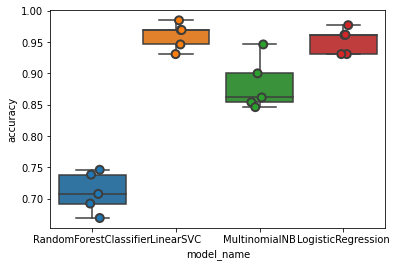

In [253]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])
import seaborn as sns
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

#### Training and Prediction

In [202]:
def training(model, training_data, y_train):
    ''' fit the model '''
    naive_bayes = model
    naive_bayes.fit(training_data, y_train)
    return naive_bayes

def get_key(value, dictionary):
    for k,v in dictionary.items():
        if value == v:
            return k

def prediction(testing_data):
    model = training(MultinomialNB(), training_data, y_train)
    predictions = model.predict(testing_data)
    predictions_keys = []
    for i in predictions:
        predictions_keys.append(get_key(i,Role_dictionary))
    print('Prediction for rows {} are \n {}'.format(X_test.index.tolist()[:10],predictions_keys[:10]))
    print(100*'#')
    actual_labels = []
    for i in y_test.tolist():
        actual_labels.append(get_key(i,Role_dictionary))
    print('Actual Labels are: \n {}'.format(actual_labels[:10]))
    print(10*'%')
    print('Accuracy score: ', format(accuracy_score(y_test,predictions)))
    return predictions

In [203]:
predictions = prediction(testing_data)

Prediction for rows [554, 227, 437, 45, 601, 211, 13, 218, 432, 97] are 
 ['Commessi delle vendite al minuto', 'Statistici', 'Camerieri di ristorante', 'Elettromeccanici', 'Commessi delle vendite al minuto', 'Statistici', 'Elettromeccanici', 'Statistici', 'Camerieri di ristorante', 'Elettromeccanici']
####################################################################################################
Actual Labels are: 
 ['Commessi delle vendite al minuto', 'Statistici', 'Camerieri di ristorante', 'Elettromeccanici', 'Commessi delle vendite al minuto', 'Statistici', 'Elettromeccanici', 'Statistici', 'Camerieri di ristorante', 'Elettromeccanici']
%%%%%%%%%%
Accuracy score:  0.9307692307692308
